<a href="https://colab.research.google.com/github/mallelamanojkumar90/AIML/blob/main/Copy_of_AIML_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression**

**Category:** Supervised Learning (Regression)

**Description:**
Linear regression models the relationship between dependent and independent variables by fitting a linear equation to observed data.

**Key Components:**
- Loss Functions: MSE, MAE, RMSE
- Formula: y = wx + b
- Optimization: Gradient Descent

**Example Application:**

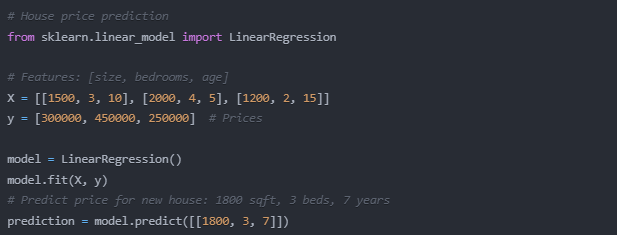


`

**Best Used For:**
- Stock price prediction
- Sales forecasting
- Temperature prediction
- Any continuous value prediction


**Instructions to implement:**
**The code includes:**

**Data Loading and Preprocessing:**

Handles missing values and duplicates
Converts features to proper numeric format
Removes outliers
Processes location data


**Exploratory Data Analysis:**

Price distribution visualization
Price vs Square Feet scatter plot
Average price by BHK
Location-wise price analysis


**Model Building:**

Feature scaling
One-hot encoding for locations
Train-test split
Linear regression implementation


**Model Evaluation:**

R-squared score
Root Mean Square Error
Actual vs Predicted plot
Residuals analysis


**Price Prediction:**

Function to predict prices for new properties

**Code:**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download the dataset from Kaggle
# Note: You need to have kaggle.json in your .kaggle folder
# Run these commands in Colab first:
'''
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amitabhajoy/bengaluru-house-price-data
!unzip bengaluru-house-price-data.zip
'''

'\n!pip install kaggle\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n!kaggle datasets download -d amitabhajoy/bengaluru-house-price-data\n!unzip bengaluru-house-price-data.zip\n'

In [3]:
# Load and prepare the dataset
def load_data():
    df = pd.read_csv('/content/sample_data/Bengaluru_House_Data.csv')
    print("Dataset Shape:", df.shape)
    return df


In [4]:
# Data preprocessing
def preprocess_data(df):
    # Remove null values
    df = df.dropna()

    # Remove duplicate entries
    df = df.drop_duplicates()

    # Convert size to numeric (extract number of BHK)
    df['bhk'] = df['size'].str.extract('(\d+)').astype(float)

    # Convert total_sqft to numeric
    def convert_sqft_to_num(x):
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1]))/2
        try:
            return float(x)
        except:
            return None

    df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
    df = df.dropna()

    # Price per square feet
    df['price_per_sqft'] = df['price']*100000/df['total_sqft']

    # Location processing
    df['location'] = df['location'].apply(lambda x: x.strip())
    location_stats = df['location'].value_counts()
    location_stats_less_than_10 = location_stats[location_stats<=10]
    df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

    # Remove outliers
    def remove_outliers(df):
        df = df[~(df['total_sqft']/df['bhk']<300)]
        df = df[df['price_per_sqft']>1000]

        def remove_price_outliers(df):
            df_out = pd.DataFrame()
            for key, subdf in df.groupby('location'):
                m = np.mean(subdf['price_per_sqft'])
                st = np.std(subdf['price_per_sqft'])
                reduced_df = subdf[(subdf['price_per_sqft']>(m-st)) & (subdf['price_per_sqft']<=(m+st))]
                df_out = pd.concat([df_out, reduced_df], ignore_index=True)
            return df_out

        return remove_price_outliers(df)

    df = remove_outliers(df)
    # Keep only important features
    df = df[['location', 'total_sqft', 'bath', 'bhk', 'price']]

    return df

In [5]:
# Data Visualization
def plot_data_insights(df):
    plt.figure(figsize=(15, 5))

    # Price Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df['price'], kde=True)
    plt.title('Price Distribution')

    # Price vs Total Square Feet
    plt.subplot(1, 3, 2)
    plt.scatter(df['total_sqft'], df['price'], alpha=0.5)
    plt.xlabel('Total Square Feet')
    plt.ylabel('Price')
    plt.title('Price vs Total Square Feet')

    # Average Price by BHK
    plt.subplot(1, 3, 3)
    sns.barplot(x='bhk', y='price', data=df)
    plt.title('Average Price by BHK')

    plt.tight_layout()
    plt.show()

    # Location-wise Price Analysis
    plt.figure(figsize=(15, 5))
    location_stats = df.groupby('location')['price'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=location_stats.index, y=location_stats.values)
    plt.xticks(rotation=45)
    plt.title('Average Price by Top 10 Locations')
    plt.show()


In [10]:
# Prepare data for modeling
def prepare_model_data(df):
    # Create dummy variables for location
    dummies = pd.get_dummies(df['location'])
    df = pd.concat([df, dummies], axis='columns')
    df = df.drop('location', axis='columns')

    # Split features and target
    X = df.drop('price', axis='columns')
    y = df['price']

    # Store feature names before scaling for prediction later
    feature_names = X.columns.to_numpy()

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names

In [7]:
# Train and evaluate model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\nModel Performance:")
    print(f"R-squared Score: {r2:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted House Prices')
    plt.tight_layout()
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Count')
    plt.show()

    return model

In [8]:
# Function to make new predictions
def predict_price(model, scaler, location, sqft, bath, bhk, locations):
    # Create input data
    input_data = np.zeros(len(locations) + 3)
    input_data[0] = sqft
    input_data[1] = bath
    input_data[2] = bhk

    # Strip whitespace from the input location
    location = location.strip()

    # Debug prints (can be removed after fixing the error)
    # print("Locations array in predict_price:", locations)
    # print("Location to search for:", location)

    loc_index = np.where(locations == location)[0][0]
    if loc_index >= 0:
        input_data[loc_index + 3] = 1

    # Scale the input
    input_data_scaled = scaler.transform(input_data.reshape(1, -1))

    # Make prediction
    return model.predict(input_data_scaled)[0]

Loading data...
Dataset Shape: (13320, 9)

Preprocessing data...

Generating data insights...


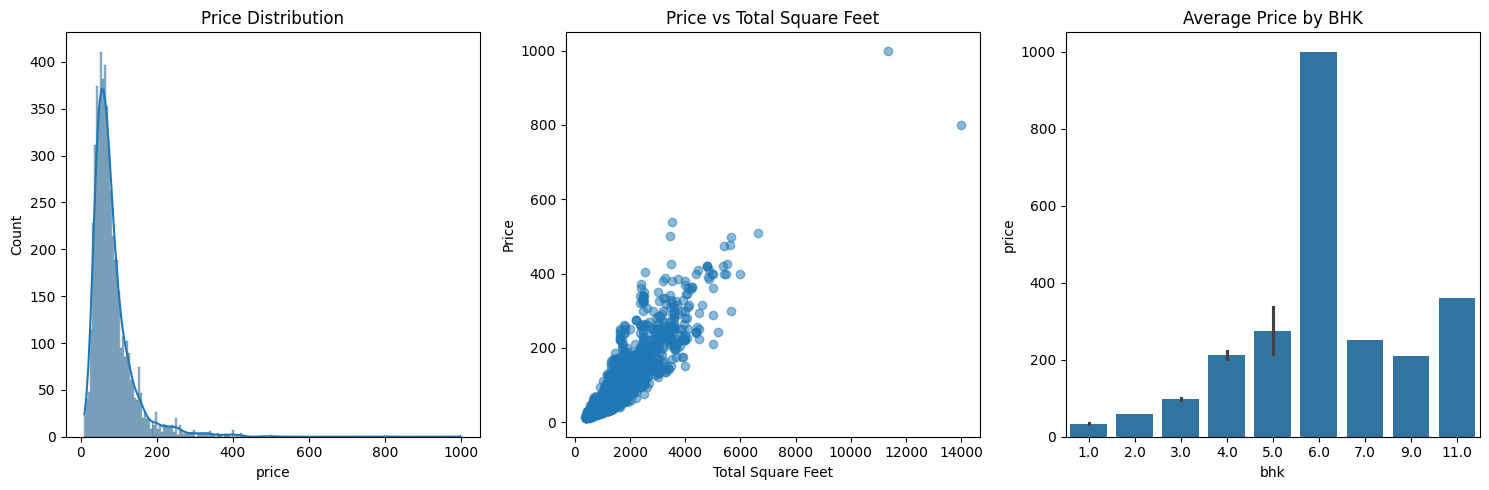

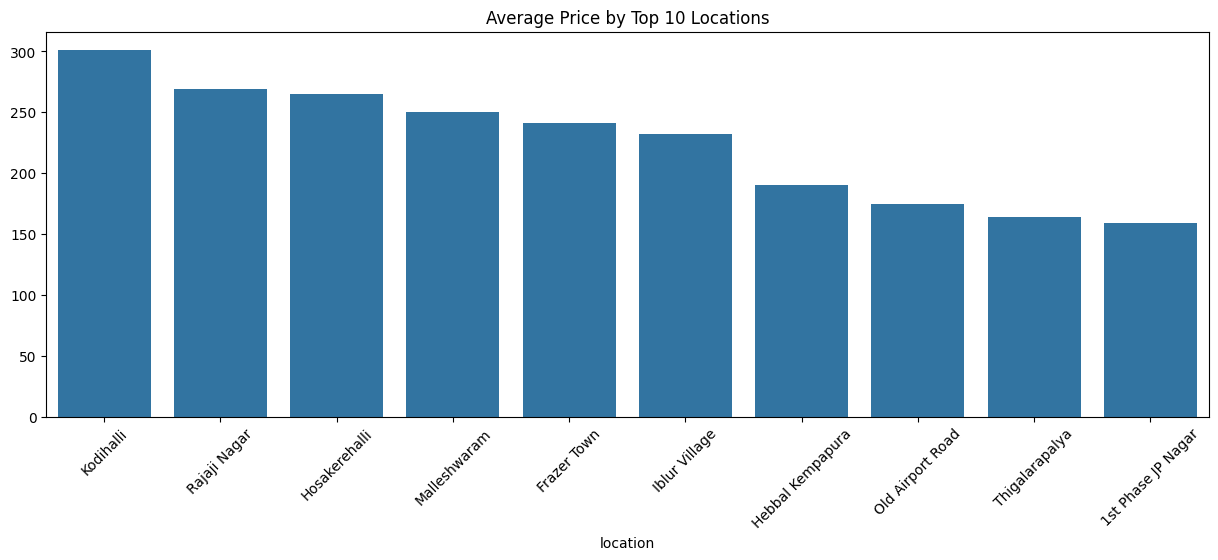


Preparing data for modeling...

Training and evaluating model...

Model Performance:
R-squared Score: 0.8948
Root Mean Square Error: 18.6273


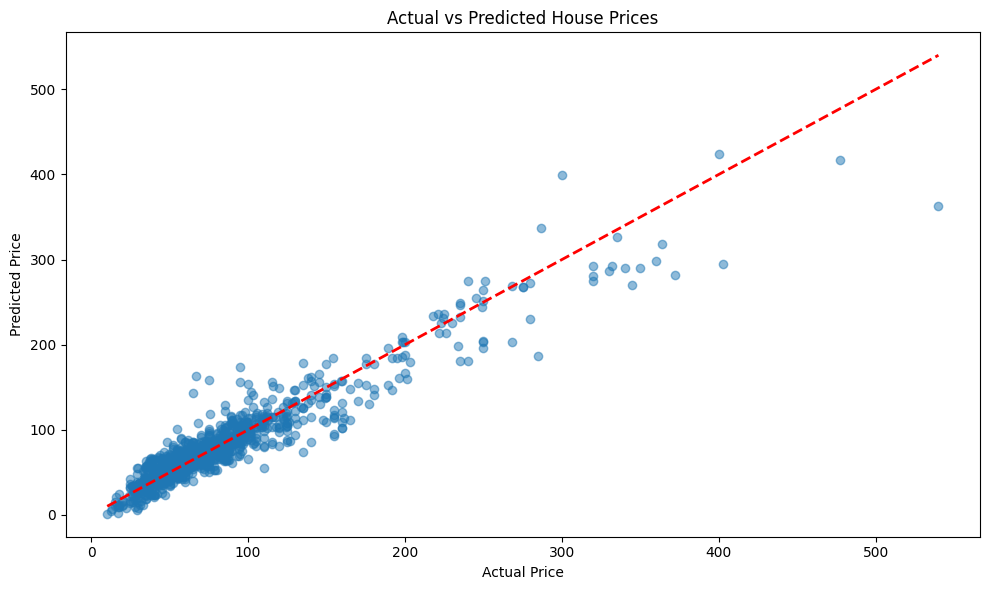

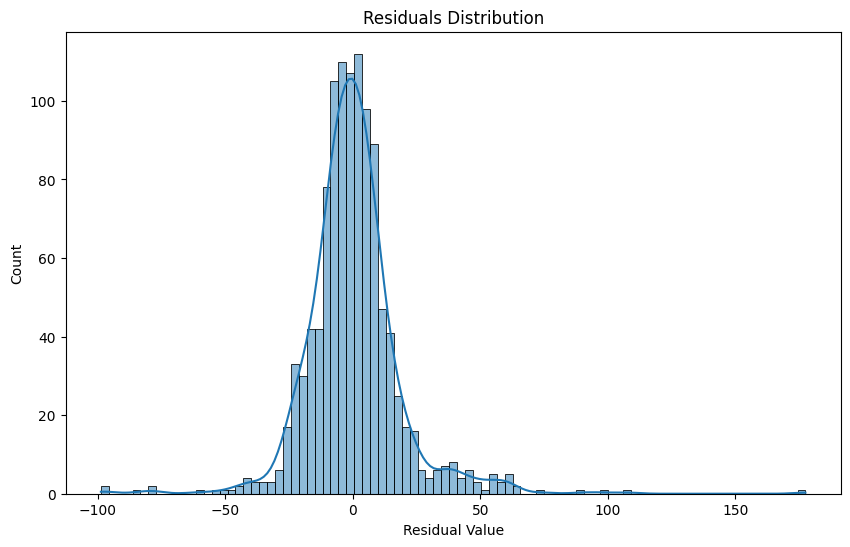


Predicted price for a 2 BHK, 1200 sqft house in other with 2 baths: ₹65.11 lakhs


In [11]:
# Main execution
def main():
    print("Loading data...")
    df = load_data()

    print("\nPreprocessing data...")
    df_processed = preprocess_data(df)

    print("\nGenerating data insights...")
    plot_data_insights(df_processed)

    print("\nPreparing data for modeling...")
    X_train, X_test, y_train, y_test, scaler, feature_names = prepare_model_data(df_processed)

    print("\nTraining and evaluating model...")
    model = train_and_evaluate_model(X_train, X_test, y_train, y_test)

    # Example prediction
    # The first 3 features are total_sqft, bath, bhk. The rest are locations.
    locations_for_prediction = feature_names[3:]

    sample_location = "other"
    predicted_price = predict_price(model, scaler, sample_location, 1200, 2, 2, locations_for_prediction)
    print(f"\nPredicted price for a 2 BHK, 1200 sqft house in {sample_location} with 2 baths: ₹{predicted_price:.2f} lakhs")

if __name__ == "__main__":
    main()